# Regression

In [1]:
#!/usr/bin/env python3

# Basic import
import numpy as np
import matplotlib.pyplot as plt

# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F


# Import models and training functions
from models import ConvNet, FFNet
from training import train_epoch, val_epoch
from functions import my_accuracy

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

#Import sys
import sys

## Data generation

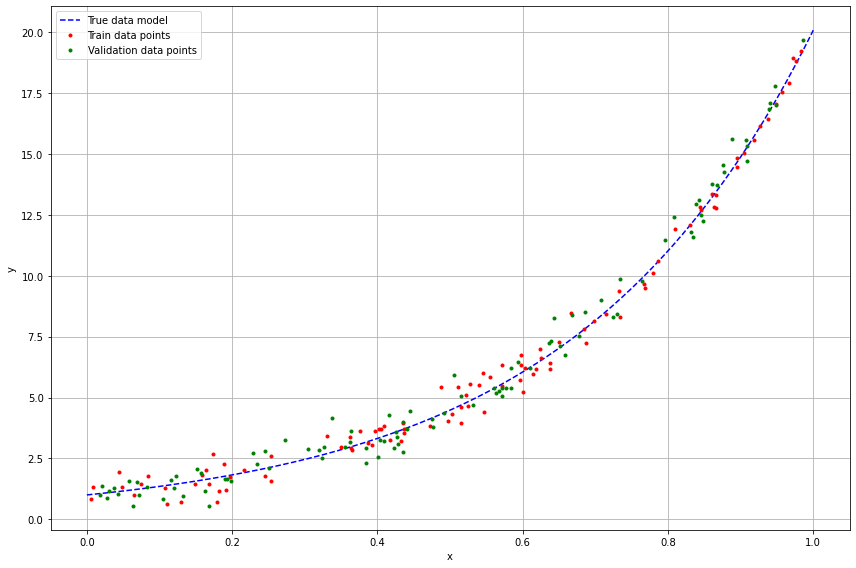

In [17]:
def exp_model(x, alpha, beta, noise_std=0):
    """
    INPUT
        x: x vector
        alpha: consant 
        beta: constant
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    noise = np.random.randn(len(x)) * noise_std
    return alpha*np.exp(beta*x) + noise

alpha = 1.0
beta = 3.0
noise_std = 0.5
np.random.seed(4)

### Train data
num_train_points = 100
x_train = np.random.rand(num_train_points)
y_train = exp_model(x_train, alpha, beta, noise_std)
with open('train_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_train, y_train)]
    f.write('\n'.join(data))
    
### Validation data
num_val_points = 100
x_val = np.random.rand(num_val_points)
y_val = exp_model(x_val, alpha, beta, noise_std)
with open('val_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_val, y_val)]
    f.write('\n'.join(data))

### Plot
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, exp_model(x_highres, alpha, beta), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_val, y_val, color='g', ls='', marker='.', label='Validation data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Dataset and dataloader

### Dataset

In [18]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.transform = transform
        
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
            
        # Get x and y values from each line and append to self.data
        self.data = []
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))
            # Now self.data contains all our dataset.
            # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

### Transforms

In [19]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
    


In [20]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('train_data.csv', transform=composed_transform)
val_dataset = CsvDataset('val_data.csv', transform=composed_transform)

### Dataloader


In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)

## Define the Network


In [22]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [ ]:
# Define the pytorch_lightning networks
parameters1 = {
    "act" : nn.ReLU, 
    "optimizer" : optim.Adam, 
    "loss_fn" : nn.CrossEntropyLoss(),
    "lr" : 0.001, 
    "weight_decay" : 0.0, 
    "drop_p" : 0.1,
    "momentum" : 0.0
}

parameters2 = {
    "act" : "ReLU", 
    "optimizer" : "RMSprop", 
    "loss_fn" : "CrossEntropyLoss",
    "lr" : 0.001, 
    "weight_decay" : 0.0, 
    "drop_p" : 0.1,
    "momentum" : 0.0,
}

parameters3 = {
    "act" : "ReLU", 
    "optimizer" : "SGD", 
    "loss_fn" : "CrossEntropyLoss",
    "lr" : 0.001, 
    "weight_decay" : 0.0, 
    "drop_p" : 0.1,
    "momentum" : 0.0,
}


# Set parameters used
parameters = parameters1

# Inizialize the network
torch.manual_seed(0)
..ff
net.to(device)